<a href="https://colab.research.google.com/github/ChristianWussow/Portfolio/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Computer Vision: Facial Emotion Categorization<center>
#### We take the FAR2013 dataset to calssify 7 different emotions from  facial pictures. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 7178 examples.


In [ ]:
# we import the necessary libraries

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Flatten, Softmax, Conv2D, MaxPooling2D, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
import keras
from keras import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import datetime
import cv2
import glob
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
# we definde our image and batch size

IMG_SIZE = (48,48)
BATCH_SIZE = 32

In [ ]:
# we take advantage of the tensorflow dataset format which automatically assigns an intger value to each class folder
# we upload the training data

train_data= image_dataset_from_directory(
    '/content/drive/MyDrive/Phyton/CLA/CNN/FER_2013/train/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=0,
    validation_split= None,
    subset= None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False

)

Found 28709 files belonging to 7 classes.


In [ ]:
# we upload the test data

test_data= image_dataset_from_directory(
    '/content/drive/MyDrive/Phyton/CLA/CNN/FER_2013/test',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=0,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 7178 files belonging to 7 classes.


In [ ]:
# we print out the 7 class names

class_names = train_data.class_names
print(class_names)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# we use the convolutional architecture of the VGG16 model but train all 14,848,327 weights by ourselves.
# --> this yields better result as working with the pretrained 'imagenet' weights.
# We also rsize the images to (224,224) as the VGG16 architecure was optimized for that resolution
# we only use the convolutional part of the VGG16 architecture and implement the fully connected layers by oursleves

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

input = tf.keras.Input(shape=(48,48,3))
x = preprocess_input(input)

x = tf.keras.layers.Resizing(224,224)(x)
x = tf.keras.layers.RandomFlip(mode='horizontal')(x)
x = tf.keras.layers.RandomRotation(0.10)(x)
x = tf.keras.layers.RandomZoom(0.10)(x)

vgg_model=tf.keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), include_top=False)


for layer in pretrained_model.layers:
     layer.trainable = True


last_layer = vgg_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)


x = vgg_model(x)

# we apply global average pooling on the output of the VGG16 convolutional part
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu', kernel_initializer='he_normal' )(x)

# the dropout layer prevents potential overfitting
x = layers.Dropout(0.3)(x)


# we have 7 emotion classes --> 7 nodes and softmax activation function 
output = layers.Dense(7, activation='softmax')(x)           

model = Model(input, output) 

model.compile(optimizer = Adam(learning_rate = 1e-4), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

last layer of vgg : output shape:  (None, 7, 7, 512)


In [ ]:
model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 tf.__operators__.getitem_22  (None, 48, 48, 3)        0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_22 (TFOpLamb  (None, 48, 48, 3)        0         
 da)                                                             
                                                                 
 resizing_17 (Resizing)      (None, 224, 224, 3)       0         
                                                                 
 random_flip_33 (RandomFlip)  (None, 224, 224, 3)      0         
                                                                 
 random_rotation_33 (RandomR  (None, 224, 224, 3)      0  

In [ ]:
# we rund the model for 50 epochs

model_history = model.fit(train_data, validation_data=test_data, epochs = 50, verbose=1,
    use_multiprocessing=True)

Train Accuracy: 0.814, Test Accuracy: 0.668


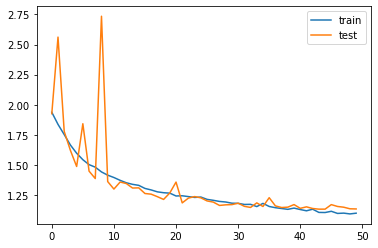

In [ ]:
_, train_acc = model.evaluate(train_data, verbose = 0)
_, test_acc = model.evaluate(test_data, verbose = 0)
print("Train Accuracy: %.3f, Test Accuracy: %.3f" % (train_acc, test_acc))
plt.plot(model_history.history['loss'], label = 'train')
plt.plot(model_history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [ ]:
# We want to compare the VGG16 architecture results with a different implementaion of our own
# here we us the original image size of (48,48) as we do not run our images through the same amount of convolutional layers as in the VGG16 model

inputs = tf.keras.Input(shape=(48,48,3))

x = tf.keras.layers.Rescaling(1/255.0)(inputs)
x = tf.keras.layers.RandomFlip(mode='horizontal')(x)
x = tf.keras.layers.RandomRotation(0.15)(x)
x = tf.keras.layers.RandomZoom(0.15)(x)



x = tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(
    filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(
    filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(
    filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(
    filters=512, kernel_size=(3, 3), activation='relu', padding='same')(x)



x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)

x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)

x = tf.keras.layers.Dropout(0.4)(x)  

x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.4)(x) 


outputs = layers.Dense(7, activation='softmax')(x)              

model = tf.keras.Model(inputs, outputs)


model.compile(optimizer = Adam(learning_rate = 1e-4), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


In [ ]:

model.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_74 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 48, 48, 3)         0         
                                                                 
 random_flip_48 (RandomFlip)  (None, 48, 48, 3)        0         
                                                                 
 random_rotation_48 (RandomR  (None, 48, 48, 3)        0         
 otation)                                                        
                                                                 
 random_zoom_48 (RandomZoom)  (None, 48, 48, 3)        0         
                                                                 
 conv2d_96 (Conv2D)          (None, 48, 48, 64)        4864      
                                                          

In [ ]:
# we also run this model for 0 epochs

model_history = model.fit(train_data, validation_data=test_data, epochs = 50, verbose=1,
    use_multiprocessing=True)

Epoch 1/50
898/898 [==============================] - 26s 27ms/step - loss: 1.8234 - accuracy: 0.2454 - val_loss: 1.7986 - val_accuracy: 0.2536
Epoch 2/50
898/898 [==============================] - 24s 27ms/step - loss: 1.7897 - accuracy: 0.2586 - val_loss: 1.7412 - val_accuracy: 0.2792
Epoch 3/50
898/898 [==============================] - 24s 26ms/step - loss: 1.7376 - accuracy: 0.2841 - val_loss: 1.6853 - val_accuracy: 0.3111
Epoch 4/50
898/898 [==============================] - 24s 26ms/step - loss: 1.6798 - accuracy: 0.3195 - val_loss: 1.5890 - val_accuracy: 0.3745
Epoch 5/50
898/898 [==============================] - 24s 26ms/step - loss: 1.5924 - accuracy: 0.3711 - val_loss: 1.4541 - val_accuracy: 0.4478
Epoch 6/50
898/898 [==============================] - 24s 26ms/step - loss: 1.5098 - accuracy: 0.4078 - val_loss: 1.3977 - val_accuracy: 0.4546
Epoch 7/50
898/898 [==============================] - 24s 26ms/step - loss: 1.4504 - accuracy: 0.4366 - val_loss: 1.3873 - val_accuracy:

Train Accuracy: 0.706, Test Accuracy: 0.619


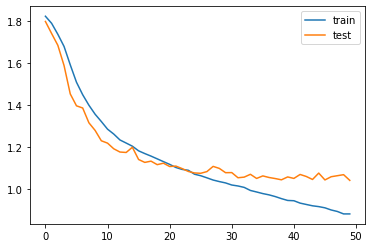

In [ ]:
_, train_acc = model.evaluate(train_data, verbose = 0)
_, test_acc = model.evaluate(test_data, verbose = 0)
print("Train Accuracy: %.3f, Test Accuracy: %.3f" % (train_acc, test_acc))
plt.plot(model_history.history['loss'], label = 'train')
plt.plot(model_history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [ ]:
print("Evaluate on test data")
results = model.evaluate(final_loader)
print("test loss, test acc:", results)

Evaluate on test data
1149/1149 [==============================] - 12s 11ms/step - loss: 1.1484 - accuracy: 0.6753
test loss, test acc: [1.1483782529830933, 0.6753308773040771]


In [ ]:
ex=[]
la = []
for images, labels in final_loader:
  la.append(labels)
  ex.append(images)


In [ ]:
pictures= ex[0][10:19]
labels = la[0][10:19]
images = pictures
predictions = model.predict(pictures)

1/1 [==============================] - 0s 23ms/step


In [ ]:


print(class_names)
print(labels)
for i in range(len(predictions)):
  #print(predictions[i].max())

  print(np.argmax(predictions[i]))

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
tf.Tensor([0 4 5 2 0 5 6 2 6], shape=(9,), dtype=int32)
4
4
5
2
0
5
6
5
6




We visualize 9 examples to see how the predicion accuracy is for the respecive class.

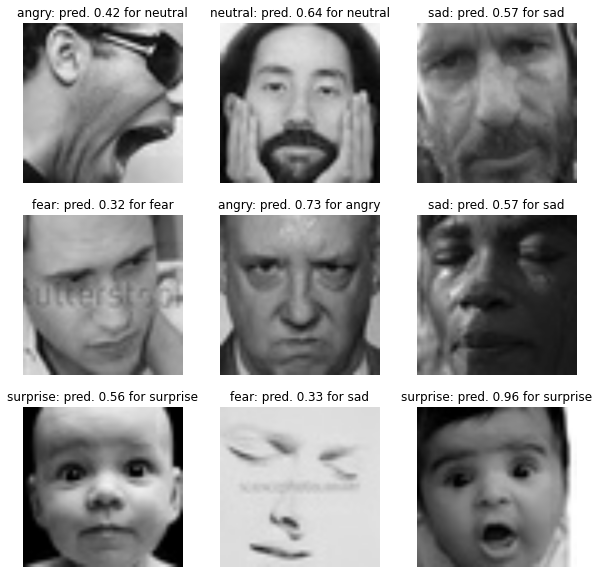

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i]/255.)
    age= labels[i]
    age= class_names[age]
    emo=np.argmax(predictions[i], axis=None)
    
    #prob = round(np.amax(predictions[i], axis=None),2)
    prob = round(float(predictions[i].max()),2)
    emo =int(np.where(predictions[i] == predictions[i].max())[0]) 
    
    group = class_names[emo]
    plt.title("{age}: pred. {prob} for {group}".format(age=age,prob=prob, group=group))
    plt.axis('off')

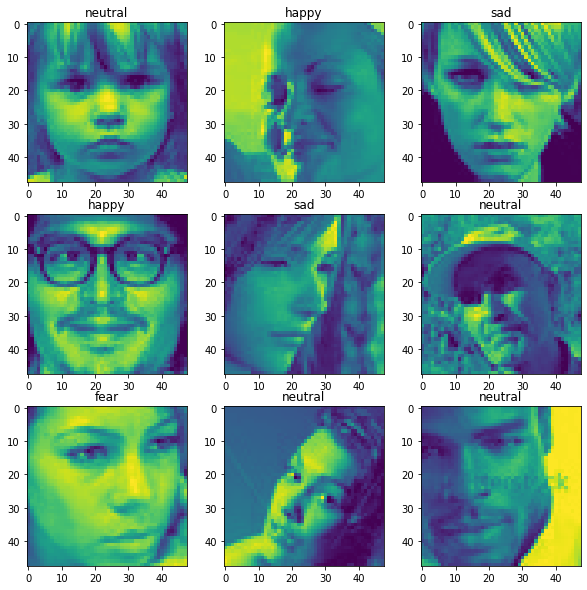

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")